<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

## 5b. Transfer Learning

So far, we have trained accurate models on large datasets, and also downloaded a pre-trained model that we used with no training necessary. But what if we cannot find a pre-trained model that does exactly what you need, and what if we do not have a sufficiently large dataset to train a model from scratch? In this case, there is a very helpful technique we can use called [transfer learning](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/).

With transfer learning, we take a pre-trained model and retrain it on a task that has some overlap with the original training task. A good analogy for this is an artist who is skilled in one medium, such as painting, who wants to learn to practice in another medium, such as charcoal drawing. We can imagine that the skills they learned while painting would be very valuable in learning how to draw with charcoal.

As an example in deep learning, say we have a pre-trained model that is very good at recognizing different types of cars, and we want to train a model to recognize types of motorcycles. A lot of the learnings of the car model would likely be very useful, for instance the ability to recognize headlights and wheels.

Transfer learning is especially powerful when we do not have a large and varied dataset. In this case, a model trained from scratch would likely memorize the training data quickly, but not be able to generalize well to new data. With transfer learning, you can increase your chances of training an accurate and robust model on a small dataset.

## 5b.1 Objectives

* Prepare a pretrained model for transfer learning
* Perform transfer learning with your own small dataset on a pretrained model
* Further fine tune the model for even better performance

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/valid/bo

bo_20.jpg  bo_22.jpg  bo_24.jpg  bo_26.jpg  bo_28.jpg
bo_21.jpg  bo_23.jpg  bo_25.jpg  bo_27.jpg  bo_29.jpg


In [ ]:
!ls /content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/vaild/not_bo

130.jpg  131.jpg  132.jpg  133.jpg  134.jpg  135.jpg  136.jpg  137.jpg	138.jpg  139.jpg  140.jpg


In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

import glob
import json
from PIL import Image

# import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [4]:
import sys
import os

# Get the current working directory
cwd = os.getcwd()

# Get the parent directory of the current working directory
parent_dir = os.path.dirname(cwd + '/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/utils.py')
print(parent_dir)

# Add the parent directory to the Python path
# This allows Python to find modules in the parent directory
sys.path.append(parent_dir)

import utils

/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB


## 5b.2 A Personalized Doggy Door

In our last exercise, we used a pre-trained [ImageNet](http://www.image-net.org/) model to let in all dogs, but keep out other animals. In this exercise, we would like to create a doggy door that only lets in a particular dog. In this case, we will make an automatic doggy door for a dog named Bo, the United States First Dog between 2009 and 2017. There are more pictures of Bo in the `data/presidential_doggy_door` folder.

<img src="data/presidential_doggy_door/train/bo/bo_10.jpg">

The challenge is that the pre-trained model was not trained to recognize this specific dog, and, we only have 30 pictures of Bo. If we tried to train a model from scratch using those 30 pictures we would experience overfitting and poor generalization. However, if we start with a pre-trained model that is adept at detecting dogs, we can leverage that learning to gain a generalized understanding of Bo using our smaller dataset. We can use transfer learning to solve this challenge.

### 5b.2.1 Downloading the Pretrained Model

The [ImageNet torchvision.models](https://pytorch.org/vision/stable/models.html) are often good choices for computer vision transfer learning, as they have learned to classify various different types of images. In doing this, they have learned to detect many different types of [features](https://developers.google.com/machine-learning/glossary#) that could be valuable in image recognition. Because ImageNet models have learned to detect animals, including dogs, it is especially well suited for this transfer learning task of detecting Bo.

Let us start by downloading the pre-trained model.

In [5]:
from torchvision.models import vgg16 # VGG16 모델 아키텍처의 인스턴스를 쉽게 생성할 수 있도록 하는 팩토리
from torchvision.models import VGG16_Weights  # VGG16에 대한 기본 사전 훈련된 가중치

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]


As we are downloading, there is going to be an important difference. The last layer of an ImageNet model is a [dense layer](https://developers.google.com/machine-learning/glossary#dense-layer) of 1000 units, representing the 1000 possible classes in the dataset. In our case, we want it to make a different classification: is this Bo or not? We will add new layers to specifically recognize Bo.

In [6]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 5b.2.2 Freezing the Base Model
Before we add our new layers onto the [pre-trained model](https://developers.google.com/machine-learning/glossary#pre-trained-model), let's take an important step: freezing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset. If they were unfrozen at this stage, we would likely destroy this valuable information. There will be an option to unfreeze and train these layers later, in a process called fine-tuning.

Freezing the base layers is as simple as setting [requires_grad_](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html) on the model to `False`.

In [7]:
vgg_model.requires_grad_(False)  # vgg_model의 가중치와 편향은 더 이상 업데이트되지 않도록 고정
print("VGG16 Frozen")

VGG16 Frozen


### 5b.2.3 Adding New Layers

We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model. In a previous lesson, we created our own [custom module](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html). A transfer learning module works in the exact same way. We can use is a layer in a [Sequential Model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

Then, we'll add a `Linear` layer connecting all `1000` of VGG16's outputs to `1` neuron.

In [8]:
N_CLASSES = 1

my_model = nn.Sequential(
    vgg_model,
    nn.Linear(1000, N_CLASSES)
)

my_model.to(device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

If we want to verify that the VGG layers are frozen, we can loop through the model [parameters](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html).

In [ ]:
# 1. idx가 2개만 증가했다는 점은 분류기의 출력층에 해당하는 nn.Linear 레이어가 추가되었을 가능성

# 2. my_model.parameters() :
# 학습 가능한 모든 파라미터(가중치, 편향)를 담고 있는 iterator를 반환
# 모델이 학습하는 과정에서 값이 업데이트되는 모든 변수들을 가져오는 역할

# 3. param.requires_grad는 해당 파라미터가 학습 가능한지 여부를 나타내는 속성
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.requires_grad)


0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 True
33 True


In [ ]:
# 데이터를 한 번에 하나씩 생성하는 특별한 함수
print(my_model.parameters())
print(type(my_model.parameters()))

<generator object Module.parameters at 0x7843e340f450>
<class 'generator'>


In [ ]:
# parameter는 Tenosr로 구성
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.size())

0 torch.Size([64, 3, 3, 3])
1 torch.Size([64])
2 torch.Size([64, 64, 3, 3])
3 torch.Size([64])
4 torch.Size([128, 64, 3, 3])
5 torch.Size([128])
6 torch.Size([128, 128, 3, 3])
7 torch.Size([128])
8 torch.Size([256, 128, 3, 3])
9 torch.Size([256])
10 torch.Size([256, 256, 3, 3])
11 torch.Size([256])
12 torch.Size([256, 256, 3, 3])
13 torch.Size([256])
14 torch.Size([512, 256, 3, 3])
15 torch.Size([512])
16 torch.Size([512, 512, 3, 3])
17 torch.Size([512])
18 torch.Size([512, 512, 3, 3])
19 torch.Size([512])
20 torch.Size([512, 512, 3, 3])
21 torch.Size([512])
22 torch.Size([512, 512, 3, 3])
23 torch.Size([512])
24 torch.Size([512, 512, 3, 3])
25 torch.Size([512])
26 torch.Size([4096, 25088])
27 torch.Size([4096])
28 torch.Size([4096, 4096])
29 torch.Size([4096])
30 torch.Size([1000, 4096])
31 torch.Size([1000])
32 torch.Size([1, 1000])
33 torch.Size([1])


If we did want to make the VGG layers trainable, we could take `vgg_model` and set `requires_grad_` to `True`.

In [ ]:
vgg_model.requires_grad_(True)
print("VGG16 Unfrozen")
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.requires_grad)

But for now, we'd only like to train our new layers, so we will turn training off.

In [9]:
vgg_model.requires_grad_(False)
print("VGG16 Frozen")

VGG16 Frozen


### 5.2.4 Compiling the Model

As with our previous exercises, we need to compile the model with loss and metrics options. We have to make some different choices here. In previous cases we had many categories in our classification problem. As a result, we picked categorical crossentropy for the calculation of our loss. In this case we only have a binary classification problem (Bo or not Bo), and so we will use [binary crossentropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Further detail about the differences between the two can found [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). We will also use binary accuracy instead of traditional accuracy.

By setting `from_logits=True` we inform the [loss function](https://gombru.github.io/2018/05/23/cross_entropy_loss/) that the output values are not normalized (e.g. with softmax).

In [10]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(my_model.parameters())
my_model = my_model.to(device)

## 5b.3 Data Augmentation

Just like in the previous lessons, we'll create a custom [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to read in picutes of Bo (and not Bo). First, we'll grab the list of preprocessing transforms from the VGG `weights`.

In [11]:
# 입력 이미지를 모델이 훈련된 데이터셋과 동일한 형식으로 변환
pre_trans = weights.transforms()
pre_trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 5b.3.1 The Dataset

Rather than read from a DataFrame like in previous lessons, we will read image files directly and infer the `label` based on the filepath.

In [12]:
DATA_LABELS = ["bo", "not_bo"]

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []

        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(l_idx).to(device).float())


    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

### 5b.3.2 The DataLoaders

Now that we have our custom Dataset class, let's create our [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders).

In [13]:
n = 32

train_path = "/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_path = "/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/valid/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

In [14]:
train_N, train_data.__len__()

(132, 132)

In [15]:
valid_N, valid_data.__len__()

(21, 21)

In [ ]:
train_data.__getitem__(0), train_data.__len__()

((tensor([[[-2.1008, -2.1179, -2.1179,  ...,  1.1529,  1.1529,  1.1187],
           [-1.9467, -2.0323, -2.0837,  ...,  1.1872,  1.1529,  1.1187],
           [-1.6384, -1.9467, -2.0665,  ...,  1.1872,  1.1358,  1.1187],
           ...,
           [ 0.3309,  0.1254,  0.3309,  ..., -0.1657, -0.2684, -0.1143],
           [ 0.3138,  0.1768,  0.2796,  ..., -0.0629,  0.3481,  0.2453],
           [ 0.1597,  0.3652,  0.2624,  ..., -0.0116, -0.1657, -0.4397]],
  
          [[ 0.2402,  0.1702,  0.1702,  ...,  1.2906,  1.2731,  1.2381],
           [ 0.6429,  0.5903,  0.5553,  ...,  1.3081,  1.2731,  1.2381],
           [ 0.8704,  0.7304,  0.5553,  ...,  1.3081,  1.2556,  1.2381],
           ...,
           [ 0.4153,  0.1877,  0.4503,  ..., -0.0924, -0.1800, -0.0224],
           [ 0.4328,  0.2577,  0.3803,  ...,  0.0126,  0.4328,  0.3452],
           [ 0.2402,  0.4678,  0.3627,  ...,  0.0826, -0.0924, -0.3550]],
  
          [[ 2.0823,  2.0300,  1.9951,  ...,  1.5245,  1.5071,  1.4897],
           

In [ ]:
train_data.__getitem__(20)

(tensor([[[-0.4739, -0.4739, -0.4739,  ..., -0.8507, -0.8335, -0.8507],
          [-0.4739, -0.4739, -0.4739,  ..., -0.8507, -0.8335, -0.8507],
          [-0.4739, -0.4739, -0.4568,  ..., -0.8507, -0.8335, -0.8507],
          ...,
          [ 0.0398,  0.0741, -0.0629,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.0569,  0.0569, -0.0629,  ..., -0.1143, -0.1143, -0.1314],
          [ 0.1426,  0.0912, -0.0458,  ..., -0.1657, -0.1657, -0.1486]],
 
         [[ 0.5903,  0.5903,  0.5903,  ...,  0.1702,  0.1877,  0.1702],
          [ 0.5903,  0.5903,  0.5903,  ...,  0.1702,  0.1877,  0.1702],
          [ 0.5903,  0.5903,  0.6078,  ...,  0.1702,  0.1877,  0.1702],
          ...,
          [ 0.1877,  0.2402,  0.1527,  ..., -0.3200, -0.3025, -0.2675],
          [ 0.1702,  0.1877,  0.1352,  ..., -0.3550, -0.3550, -0.3375],
          [ 0.1877,  0.1877,  0.1352,  ..., -0.4076, -0.3901, -0.3550]],
 
         [[ 0.8099,  0.8099,  0.8099,  ...,  0.3568,  0.3742,  0.3568],
          [ 0.8099,  0.8099,

### 5b.3.3 Data Augmentation

Let's apply some data augmentation so the model can have a better chance at recognizing Bo. This time, we have color images, so we can use [ColorJitter](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#colorjitter) to full effect.

In [16]:
# VGG16 모델은 (224, 224, 3) 형태의 이미지 크기 입력

IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2)
])

## 5b.4 The Training Loop

We will use most of the same training loop as before but with a few slight differences. First, our `get_batch_accuracy` function will be different because of using [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) as our loss function. We could run the output through the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function, but we can be more efficient by being mathematically observant.

When our model `output` is greater than `0`, running it through the sigmoid function would be closer to `1`. When the model `output` is less than `0`, running it through the sigmoid function would be closer to `0`. Therefore, we only need to check if the model output is greater than ([gt](https://pytorch.org/docs/stable/generated/torch.gt.html)) `0` to see which class our prediction leans towards.

In [17]:
def get_batch_accuracy(output, y, N):
    # 모델의 출력(output)을 0과 비교하여 이진 분류 예측을 생성
    # output 값이 0보다 크면 True (예: 클래스 1), 0보다 작거나 같으면 False (예: 클래스 0)로 예측
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)

    # .view_as(pred) : 텐서의 크기(shape)를 다른 텐서의 크기와 동일하게 변경하는 함수
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

We also section to print the last set of gradients to show that only our newly added layers are learning.

In [18]:
train_loss, train_accuracy = [],[]

def train(model, check_grad=False):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = torch.squeeze(model(random_trans(x)))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)

    ######
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    ######

    if check_grad:
        print('Last Gradient:')
        for param in model.parameters():
            print(param.grad)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

Uncomment the below to see a sample of the model's gradients. Because VGG16 ends in 1000 neurons, there are 1000 weights connected to the single neuron in the next layer. Many numbers will be printed!

In [ ]:
# True로 설정된 경우, 모델의 모든 매개변수에 대한 기울기를 콘솔에 출력
# 이는 모델 학습 과정을 디버깅하고 기울기가 제대로 계산되고 있는지 확인하는 데 유용
train(my_model, check_grad=True)

Last Gradient:
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
tensor([[ 2.2258e-01, -2.0325e-01, -1.0666e-01, -2.8187e-01, -3.4207e-01,
         -4.6522e-01, -3.7738e-01,  4.0263e-01,  2.6547e-01,  3.2537e-01,
          2.1449e-01,  3.6851e-01,  2.9513e-01,  1.8399e-01,  1.4885e-01,
          2.1794e-01,  2.8219e-01,  5.0777e-02,  1.6583e-01,  8.5083e-02,
          2.8722e-01,  2.0365e-01,  2.6025e-01,  2.0992e-01,  1.0181e-01,
          1.8140e-01, -1.1929e-01,  1.1407e-01,  1.7491e-01, -1.4643e-01,
          1.3971e-01, -6.9233e-02, -4.5038e-02, -3.8012e-01, -4.2632e-01,
          1.7341e-01, -2.2461e-01,  1.9117e-01, -4.1150e-01, -7.8404e-02,
         -5.2899e-02,  3.3075e-02, -3.3577e-02, -2.2609e-01,  1.3901e-01,
         -1.3139e-01, -3.0636e-02, -4.1634e-01,  5.5278e-02, -4.0558e-02,
         -1.4454e-01, -4.1334e-01,  2.4929e-01,  2.9730e-01,  1.7150e-02,
          9

In [ ]:
# model.zero_grad() 함수는 일반적으로 매 반복(iteration) 시작 시에 호출하여 이전 반복의 기울기를 초기화 함
# 따라서 model.zero_grad()를 호출한 후에 기울기를 확인하면 None이 출력

The `validate` function mostly remains the same:

In [19]:
valid_loss, valid_accuracy = [],[]

def validate(model):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = torch.squeeze(model(x))

            loss += loss_function(output, y.float()).item()
            accuracy += get_batch_accuracy(output, y, valid_N)

    ######
    valid_loss.append(loss)
    valid_accuracy.append(accuracy)
    ######
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

Moment of truth: can the model learn to recognize Bo?

In [20]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0
Train - Loss: 2.0661 Accuracy: 0.8258
Valid - Loss: 0.2556 Accuracy: 0.9048
Epoch: 1
Train - Loss: 1.3990 Accuracy: 0.8333
Valid - Loss: 0.1680 Accuracy: 0.9524
Epoch: 2
Train - Loss: 1.4849 Accuracy: 0.8636
Valid - Loss: 0.1741 Accuracy: 0.9524
Epoch: 3
Train - Loss: 1.3691 Accuracy: 0.8712
Valid - Loss: 0.2511 Accuracy: 0.9524
Epoch: 4
Train - Loss: 1.5339 Accuracy: 0.9167
Valid - Loss: 0.3970 Accuracy: 0.8095
Epoch: 5
Train - Loss: 0.9832 Accuracy: 0.9167
Valid - Loss: 0.4026 Accuracy: 0.8095
Epoch: 6
Train - Loss: 1.1211 Accuracy: 0.8636
Valid - Loss: 0.2404 Accuracy: 0.8571
Epoch: 7
Train - Loss: 0.8939 Accuracy: 0.8864
Valid - Loss: 0.1391 Accuracy: 0.9524
Epoch: 8
Train - Loss: 0.9177 Accuracy: 0.9091
Valid - Loss: 0.0723 Accuracy: 0.9524
Epoch: 9
Train - Loss: 1.4950 Accuracy: 0.8788
Valid - Loss: 0.0441 Accuracy: 1.0000


In [21]:
train_loss, valid_loss

([2.066058784723282,
  1.398982360959053,
  1.4849133789539337,
  1.3691312223672867,
  1.5338806360960007,
  0.9831559658050537,
  1.12106254696846,
  0.8938773069530725,
  0.9177280925214291,
  1.4950451701879501],
 [0.2556062340736389,
  0.16798074543476105,
  0.17410005629062653,
  0.25111210346221924,
  0.3969842493534088,
  0.4025970697402954,
  0.24042922258377075,
  0.13910147547721863,
  0.07234777510166168,
  0.044084589928388596])

In [22]:
train_accuracy, valid_accuracy

([0.8257575757575757,
  0.8333333333333333,
  0.8636363636363636,
  0.8712121212121212,
  0.9166666666666667,
  0.9166666666666667,
  0.8636363636363636,
  0.8863636363636364,
  0.9090909090909091,
  0.8787878787878788],
 [0.9047619047619048,
  0.9523809523809523,
  0.9523809523809523,
  0.9523809523809523,
  0.8095238095238095,
  0.8095238095238095,
  0.8571428571428571,
  0.9523809523809523,
  0.9523809523809523,
  1.0])

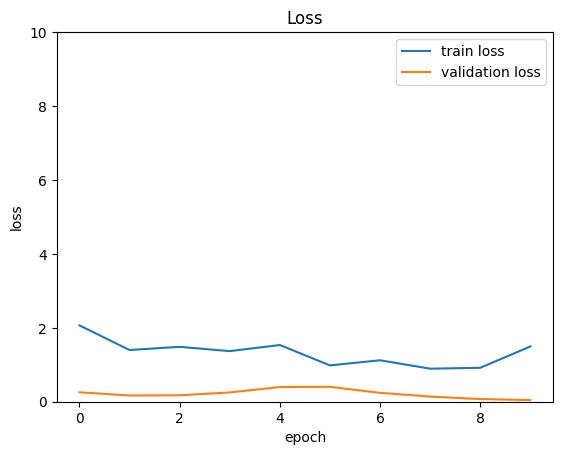

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Loss')
plt.plot(train_loss, label = 'train loss')
plt.plot(valid_loss, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 10])
plt.legend(loc='upper right')
plt.show()

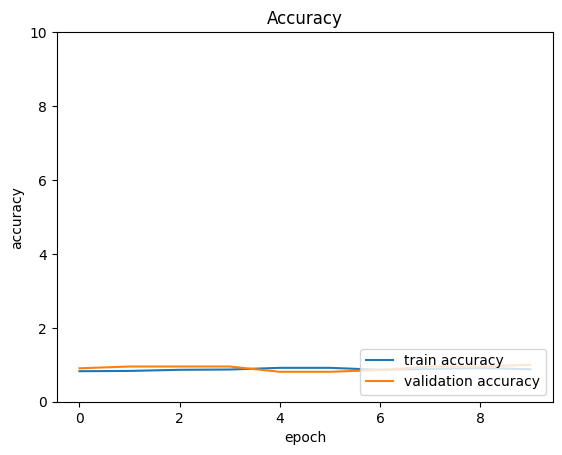

In [30]:
plt.title('Accuracy')
plt.plot(train_accuracy, label = 'train accuracy')
plt.plot(valid_accuracy, label = 'validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.show()

## Discussion of Results

Both the training and validation accuracy should be quite high. This is a pretty awesome result! We were able to train on a small dataset, but because of the knowledge transferred from the ImageNet model, it was able to achieve high accuracy and generalize well. This means it has a very good sense of Bo and pets who are not Bo.

If you saw some fluctuation in the validation accuracy, that is okay too. We have a technique for improving our model in the next section.

## Fine-Tuning the Model

Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called [fine-tuning](https://developers.google.com/machine-learning/glossary#f). To do this we unfreeze the entire model, and train it again with a very small [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate). This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount. VGG16 is a relatively large model,so the small learning rate will also prevent overfitting.

Note that it is important to only do this step after the model with frozen layers has been fully trained. The untrained linear layer that we added to the model earlier was randomly initialized. This means it needed to be updated quite a lot to correctly classify the images. Through the process of [backpropagation](https://developers.google.com/machine-learning/glossary#backpropagation), large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

Let's try unfreezing the pre-trained layers, and then fine tuning the model:

In [31]:
# Unfreeze the base model
vgg_model.requires_grad_(True)
optimizer = Adam(my_model.parameters(), lr=.000001)

In [32]:
epochs = 2

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0
Train - Loss: 0.9092 Accuracy: 0.9242
Valid - Loss: 0.0470 Accuracy: 1.0000
Epoch: 1
Train - Loss: 1.2891 Accuracy: 0.8939
Valid - Loss: 0.0481 Accuracy: 1.0000


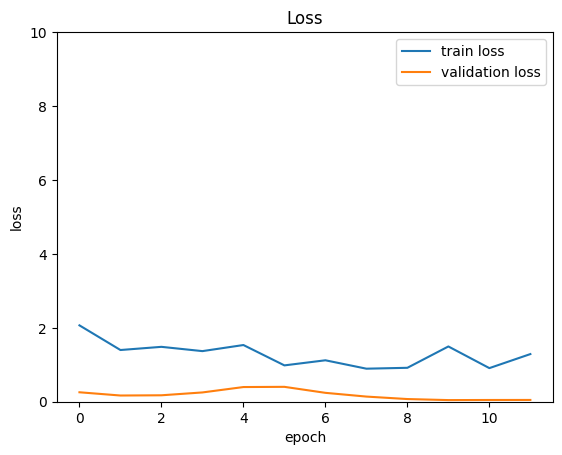

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Loss')
plt.plot(train_loss, label = 'train loss')
plt.plot(valid_loss, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 10])
plt.legend(loc='upper right')
plt.show()

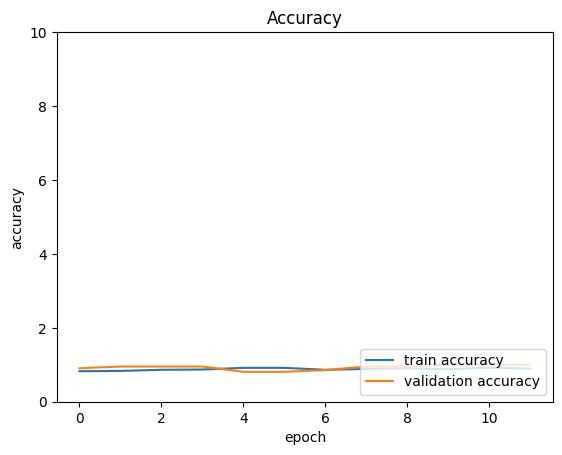

In [34]:
plt.title('Accuracy')
plt.plot(train_accuracy, label = 'train accuracy')
plt.plot(valid_accuracy, label = 'validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.show()

In this case, we'll only train for a few `epochs`. Because VGG16 is such a large model, it can overfit when it trains for too long on this dataset.

## Examining the Predictions

Now that we have a well-trained model, it is time to create our doggy door for Bo! We can start by looking at the predictions that come from the model. We will preprocess the image in the same way we did for our last doggy door.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

In [ ]:
def make_prediction(file_path):
    show_image(file_path)
    image = Image.open(file_path)
    image = pre_trans(image).to(device)
    image = image.unsqueeze(0)
    output = my_model(image)
    prediction = output.item()
    return prediction

Try this out on a couple images to see the predictions:

-4.079957485198975

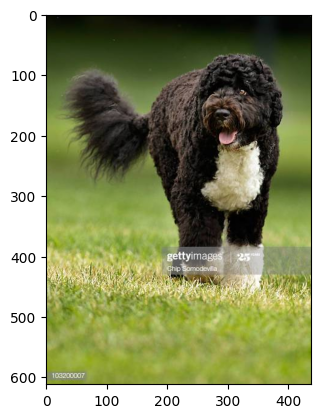

In [ ]:
make_prediction('/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/vaild/bo/bo_20.jpg')

9.473227500915527

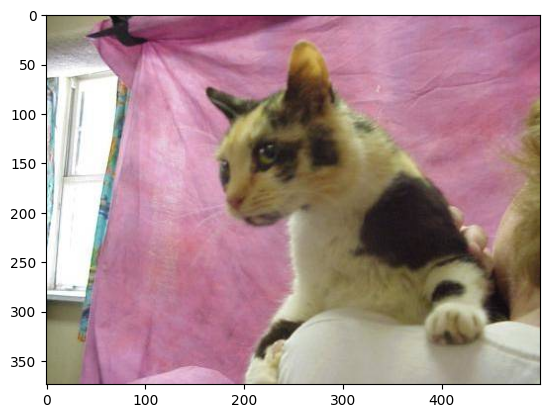

In [ ]:
make_prediction('/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/vaild/not_bo/121.jpg')

It looks like a negative number prediction means that it is Bo and a positive number prediction means it is something else. We can use this information to have our doggy door only let Bo in!

## Exercise: Bo's Doggy Door

Fill in the following code to implement Bo's doggy door:

In [ ]:
def presidential_doggy_door(image_path):
    pred = make_prediction(image_path)
    if pred < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

## Solution

Click on the '...' below to see the solution.

In [ ]:
# SOLUTION
def presidential_doggy_door(image_path):
    pred = make_prediction(image_path)
    if pred < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

Let's try it out!

That's not Bo! Stay out!


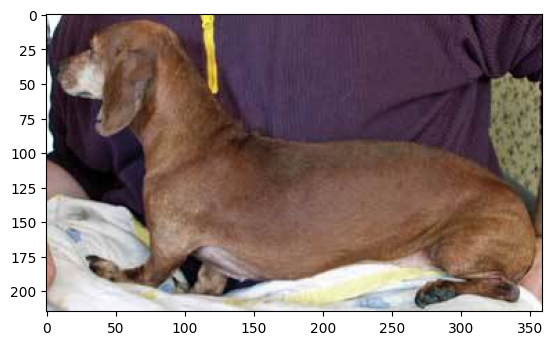

In [ ]:
presidential_doggy_door('/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/vaild/not_bo/130.jpg')

It's Bo! Let him in!


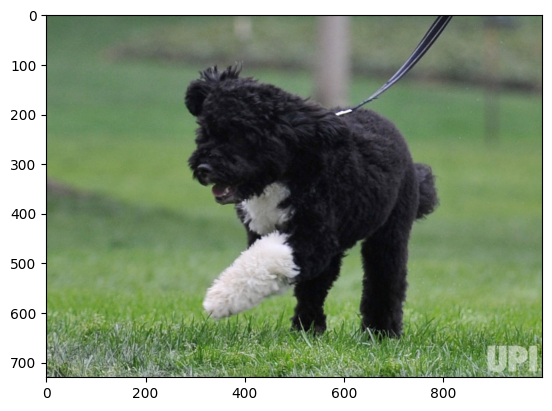

In [ ]:
presidential_doggy_door('/content/drive/MyDrive/강의자료/DLI_FDL_EN/LAB/data/presidential_doggy_door/vaild/bo/bo_29.jpg')

## Summary

Great work! With transfer learning, you have built a highly accurate model using a very small dataset. This can be an extremely powerful technique, and be the difference between a successful project and one that cannot get off the ground. We hope these techniques can help you out in similar situations in the future!

There is a wealth of helpful resources for transfer learning in the [NVIDIA TAO Toolkit](https://developer.nvidia.com/tlt-getting-started).

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Next

So far, the focus of this workshop has primarily been on image classification. In the next section, in service of giving you a more well-rounded introduction to deep learning, we are going to switch gears and address working with sequential data, which requires a different approach.

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>